This notebook extends on the taxi models notebook. In that notebook we did some exploratory analysis and linear fits to get baselines for the price/(distance and time) for the two datasets. This leaves out plenty of potentially useful information like time of day, shared rides, and location. In this notebook we do the following:

1. Clean the data and prune appropriate vairables with a pipeline, potentially save a clean copy.
 - Convert certain columns into useful derived variables eg.. ride speed, hour, day of week.
 - Delete unused columns.
 - Consider variable scaling. Do we want to just use raw lat/long or perhaps normalize to center of chicago?
 - Prepare data in X, Y format for ML algorithms and train/test split.
 - I think surge pricing is the only way which the taxi vs TNP datasets differ in a useful way.
 
 
specific features (https://www.kaggle.com/headsortails/nyc-taxi-eda-update-the-fast-the-curious)

1. Airport boolean from lat/long.
2.

In [1]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
from IPython.display import Image
#from tqdm.auto import tqdm  # for progress bars

import numpy as np
import random
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


# Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [8]:
store.get_storer('df')

frame_table  (typ->appendable,nrows->25860156,ncols->14,indexers->[index])

In [89]:
# generates easy-to-load ~2gb files from ~10gb of input data.
%run -i 'inital_preprocessing.py'
def load_hdf(path, percent = 100):
    if percent == 100:
        return pd.read_hdf(path, 'df')
    else:
        store = pd.HDFStore(path)
        nrows = store.get_storer('df').nrows
        r = np.random.randint(0,nrows,size=int(nrows*percent/100))
        store.close()
        return pd.read_hdf(path, 'df',where=pd.Index(r))
        
        
taxi = load_hdf(taxi_out_path,1)
tnp = load_hdf(tnp_out_path, 1)
print(taxi.info(), tnp.info())

Nothing to be done, h5 files exist.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 258601 entries, 6832510 to 22381177
Data columns (total 14 columns):
Trip Start Timestamp          258601 non-null datetime64[ns]
Trip Seconds                  258566 non-null float32
Trip Miles                    258596 non-null float32
Pickup Community Area         227710 non-null float32
Dropoff Community Area        223190 non-null float32
Fare                          258596 non-null float32
Tips                          258596 non-null float32
Tolls                         258596 non-null float32
Extras                        258596 non-null float32
Trip Total                    258596 non-null float32
Pickup Centroid Latitude      227715 non-null float64
Pickup Centroid Longitude     227715 non-null float64
Dropoff Centroid Latitude     223710 non-null float64
Dropoff Centroid Longitude    223710 non-null float64
dtypes: datetime64[ns](1), float32(9), float64(4)
memory usage: 20.7 MB
<class 'pa

<Figure size 432x288 with 0 Axes>

## Pandas Preprocessing
We have enough data that I want to drop rather than impute missing values. We also want to restrict the model based on reasonable fares and distances.

In [90]:
type_map = {"Trip_Seconds": "uint16",
            "Pickup_Community_Area": "category",
            "Dropoff_Community_Area": "category"}

def preprocess_trip_data(df,max_fare = 200, max_miles = 100, max_time = int(1e4),bTaxi = True):
    df.columns = df.columns.str.replace(' ', '_') # for dot notation
    df.columns = df.columns.str.replace('Tips', 'Tip')
    df.dropna(inplace = True)
    # Drop trips with outlier distances or times
    df.drop(df[(df.Trip_Miles <=0)|(df.Trip_Miles >max_miles)].index, inplace=True)
    df.drop(df[(df.Trip_Seconds <=0)|(df.Trip_Seconds >max_time)].index, inplace=True)
    # Add velocity column to further screen data
    df['vel_mph'] = df['Trip_Miles']/(df['Trip_Seconds']/3600) #in mi/hr
    #drop insane velocities
    df.drop(df[df.vel_mph >= 60].index,inplace = True)
    # drop unusually large or small fares
    df.drop(df[((df.Fare <= 0)|(df.Fare > max_fare))].index,inplace = True)
    # define a final fare, includes every fee other than tip
    df['Final_Fare'] = df['Trip_Total'] -df['Tip']

    if bTaxi:
        df.drop(['Fare', 'Tip', 'Tolls', 'Extras','Trip_Total'],axis =1, inplace = True)
    else:
        df.drop(['Fare', 'Tip', 'Additional_Charges','Trip_Total'],axis =1, inplace = True)

In [91]:
#preprocess_trip_data(tnp)
preprocess_trip_data(taxi)
# Python holds on to the extra memory unless you flush...
%reset Out 

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Flushing output cache (0 entries)


In [92]:
#preprocess_trip_data(tnp)
preprocess_trip_data(tnp, bTaxi = False)
# Python holds on to the extra memory unless you flush...
%reset Out 

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Flushing output cache (0 entries)


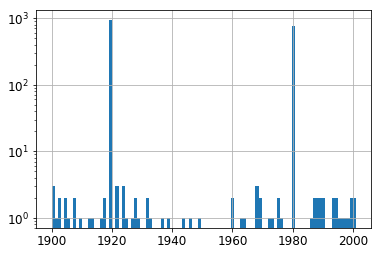

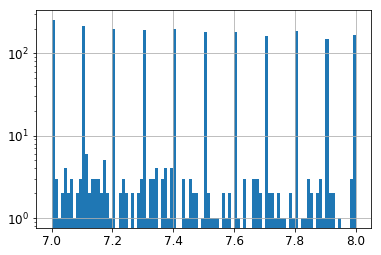

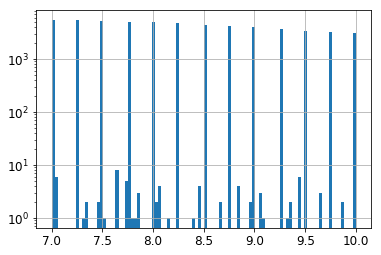

In [79]:
# significant rounding to nearest minute in the taxi data
# Similar but for (4?) seconds in tnp.
taxi.Trip_Seconds.hist(bins = 100,log = True, range = [1900,2001])
plt.show()
# sifnificant rounding to nearest 10th of a mile
taxi.Trip_Miles.hist(bins = 100,log = True, range = [7,8])
plt.show()
# Taxi fare has a strong preference to quarter dollars,
# tnp is similar but bins are larger at 2.5 dollars.
taxi.Final_Fare.hist(bins = 100,log = True, range = [7,10])

### Extra Features

#### Latitude and Longitude to distance and bearing.
This webpage explains how to get distance and bearing from lat/long:
http://www.movable-type.co.uk/scripts/latlong.html

In [43]:
from geopy import distance
newport_ri = (41.49008, -71.312796)
cleveland_oh = (41.499498, -81.695391)
print(distance.great_circle(newport_ri, cleveland_oh).km)

AVG_EARTH_RADIUS = 6371.009  # in km

def haversine_dist(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    km = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return km

def bearing(lat1, lng1, lat2, lng2):
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

def manhattan_dist(lat1, lng1, lat2, lng2):
    x = haversine_dist(lat1,lng1,lat1,lng2)
    y = haversine_dist(lat1,lng1,lat2,lng1)
    return x+y

lat1,lng1 = (41.49008, -71.312796)
lat2,lng2 =  (41.499498, -81.695391)
# almost identical to geopy
haversine_dist(lat1, lng1, lat2, lng2)
manhattan_dist(lat1, lng1, lat2, lng2)


864.2144943393625


865.3240204118771

In [48]:
# Note that about 10% of trips start and end in the same lat/area so these will be zero.
def add_dist_and_bearing(df):
    df["l2_dist_km"] = haversine_dist(df["Pickup_Centroid_Latitude"],
                                       df["Pickup_Centroid_Longitude"],
                                       df["Dropoff_Centroid_Latitude"],
                                       df["Dropoff_Centroid_Longitude"])
    df["l1_dist_km"] = manhattan_dist(df["Pickup_Centroid_Latitude"],
                                       df["Pickup_Centroid_Longitude"],
                                       df["Dropoff_Centroid_Latitude"],
                                       df["Dropoff_Centroid_Longitude"])
    df["bearing"] = bearing(df["Pickup_Centroid_Latitude"],
                               df["Pickup_Centroid_Longitude"],
                               df["Dropoff_Centroid_Latitude"],
                               df["Dropoff_Centroid_Longitude"])



In [61]:
add_dist_and_bearing(taxi)
taxi[taxi.bearing == 0].count()

Trip_Start_Timestamp          178255
Trip_Seconds                  178255
Trip_Miles                    178255
Pickup_Community_Area         178255
Dropoff_Community_Area        178255
Pickup_Centroid_Latitude      178255
Pickup_Centroid_Longitude     178255
Dropoff_Centroid_Latitude     178255
Dropoff_Centroid_Longitude    178255
Final_Fare                    178255
vel                           178255
day                           178255
hour                          178255
bAirport                      178255
l2_dist_km                    178255
l1_dist_km                    178255
bearing                       178255
dtype: int64

#### Airport

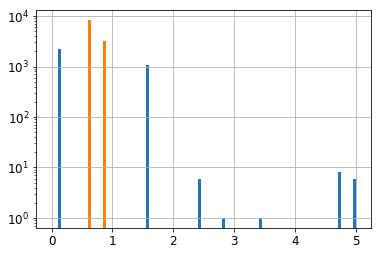

In [36]:
midway = (41.7868, -87.7522)
ohare = (41.9742, -87.9073)

haversine_dist(taxi["Pickup_Centroid_Latitude"],
               taxi["Pickup_Centroid_Longitude"],
              midway[0],
              midway[1]).hist(bins = 100, range = [0,5],log = True)

haversine_dist(taxi["Pickup_Centroid_Latitude"],
               taxi["Pickup_Centroid_Longitude"],
              ohare[0],
              ohare[1]).hist(bins = 100,range = [0,5])

It seems reasonable to include trips within 1km of the airport as airport trips.

In [97]:
def add_airport_col(df,thresh_km = 1.5):
    midway = (41.7868, -87.7522)
    ohare = (41.9742, -87.9073)
    airport_flag = haversine_dist(df["Pickup_Centroid_Latitude"],
                   df["Pickup_Centroid_Longitude"],
                   midway[0],
                   midway[1]) < thresh_km
    airport_flag |= haversine_dist(df["Pickup_Centroid_Latitude"],
                   df["Pickup_Centroid_Longitude"],
                   ohare[0],
                   ohare[1]) < thresh_km
    print(f"Airport trips pecentage: {airport_flag.mean()*100}")
    df["bAirport"] = airport_flag


In [38]:
add_airport_col(taxi)

Airport trips pecentage: 7.708058679980927


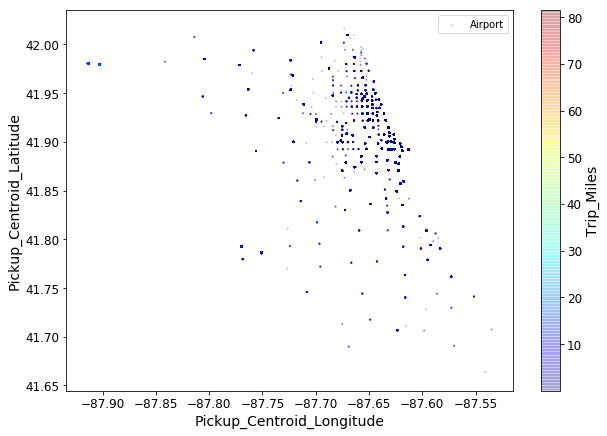

In [41]:
taxi.plot(kind = "Scatter", x = "Pickup_Centroid_Longitude", y = "Pickup_Centroid_Latitude", alpha = 0.2,
            s = taxi["bAirport"], label = "Airport", figsize = (10,7),
            c = "Trip_Miles", cmap = plt.get_cmap('jet'),colorbar = True, sharex=False
)

#### Datetime

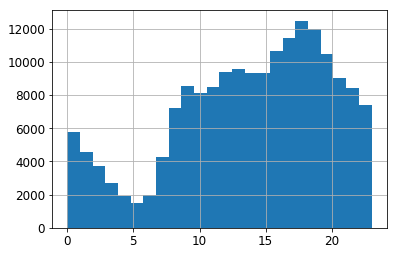

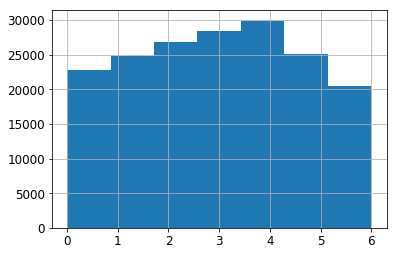

In [68]:
    #Define some new attributes
# use day and hour as categorical
taxi.Trip_Start_Timestamp.dt.hour.hist(bins = 24)
plt.show()
taxi.Trip_Start_Timestamp.dt.dayofweek.hist(bins = 7)

In [69]:
def add_datetime_vars(df):
    df['day_of_wk'] = df.Trip_Start_Timestamp.dt.dayofweek.astype('category')
    df['hour'] = df.Trip_Start_Timestamp.dt.hour.astype('category')

#### Adding all features

In [81]:
def add_all_features(df):
    add_dist_and_bearing(df)
    add_airport_col(df,thresh_km = 1.5)
    add_datetime_vars(df)

In [99]:
add_all_features(taxi)
add_all_features(tnp)

Airport trips pecentage: 7.733867438650822
Airport trips pecentage: 2.6398207315694635


In [100]:
tnp.groupby("bAirport").Final_Fare.mean()

bAirport
False    11.552732
True     33.488869
Name: Final_Fare, dtype: float32

In [98]:
tnp.columns

Index(['Trip_Start_Timestamp', 'Trip_Seconds', 'Trip_Miles',
       'Pickup_Community_Area', 'Dropoff_Community_Area',
       'Shared_Trip_Authorized', 'Pickup_Centroid_Latitude',
       'Pickup_Centroid_Longitude', 'Dropoff_Centroid_Latitude',
       'Dropoff_Centroid_Longitude', 'vel_mph', 'Final_Fare', 'l2_dist_km',
       'l1_dist_km', 'bearing'],
      dtype='object')